In [1]:

import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

from pathos.multiprocessing import ProcessPool
import src.Simulator as sim_system
import src.Optimizer as opt
import src.SimGrad as sim_diff
import src.Grad_based_methods as grad_based
import scipy as sp
import numpy as np
import torch
import tqdm
import time


###* Create Simulator object
reactions_file = "../reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                    'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                    'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"
exp_file = os.path.join(output_folder_path, exp_data_file)

sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)



###* Create optimization and diff objects

def func_optimization(params, flag='numpy'):
    
    SF_vec = params
    
    dict_mod_vec = [
    {"id": 1, "rate": None, "model_dict": {"SF": None}},
    {"id": 2, "rate": None, "model_dict": {"SF": None}},
    {"id": 3, "rate": None, "model_dict": {"SF": None}},
    {"id": 4, "rate": None, "model_dict": {"SF": None}},
    {"id": 5, "rate": None, "model_dict": {"SF": None}},
    {"id": 6, "rate": None, "model_dict": {"SF": None}},
    {"id": 7, "rate": None, "model_dict": {"SF": None}},
    {"id": 8, "rate": None, "model_dict": {"SF": None}},
    {"id": 9, "rate": None, "model_dict": {"SF": None}},
    {"id": 10, "rate": None, "model_dict": {"SF": None}},
    ]
        
    for i in range(len(params)):
        dict_mod_vec[i]['model_dict']['SF'] = SF_vec[i]
    
    dict_mod_vec = [dict_mod_vec[i] for i in range(len(params))]
    return dict_mod_vec


def loss_function(exp, teo, flag='numpy'):
    
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")



###* Optimization
def loss_and_grads(params, opt_object, diff_object):
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    
    return loss_val, grad_val.numpy()



def loss_grad_num(params, opt_object, h_step = 1e-3):
    loss2grad_vec = np.zeros(len(params), dtype=float)
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += h_step
        params_minus = params.copy()
        params_minus[i] -= h_step
        
        loss_plus, _, _, _, _ = opt_object.objective_function_diff(params_plus)
        loss_minus, _, _, _, _ = opt_object.objective_function_diff(params_minus)
        
        loss2grad_vec[i] = (loss_plus - loss_minus)/(2*h_step)
    
    return loss2grad_vec



  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [2]:


sample_size = 12
torch_vec = []
torch_time = []

num_vec = []
num_time = []

pbar = tqdm.tqdm(total=10*sample_size)


##! define the default parameters
for n in range(1, 11):
    torch_time_aux = []
    torch_vec_aux = []
    num_time_aux = []
    num_vec_aux = []
    params_default = [1.0]*n
    
    optimizer = opt.Optimizer(sim, 
                            lambda params: func_optimization(params, 'numpy'), 
                            lambda exp, teo: loss_function(exp, teo, 'numpy')
                            )
    
    diff = sim_diff.SimDiff(sim, 
                            lambda params: func_optimization(params, 'torch'),
                            params_default=params_default,
                            gamma_exp_data=sim.gamma_exp_data_arr,
                            loss_function=lambda exp, teo: loss_function(exp, teo, 'torch')
                            )
        
    for i in range(sample_size):
        params_default = np.array(params_default) + 1e-2*np.random.randn(len(params_default))
        
        time_init = time.time()
        loss, grads = loss_and_grads(params_default, optimizer, diff)
        torch_time_aux.append(time.time() - time_init)
        torch_vec_aux.append(grads)
        
        time_init = time.time()
        grads = loss_grad_num(params_default, optimizer)
        num_time_aux.append(time.time() - time_init)
        num_vec_aux.append(grads)
        
        pbar.update(1)
    
    torch_time.append(torch_time_aux)
    torch_vec.append(torch_vec_aux)
    
    num_time.append(num_time_aux)
    num_vec.append(num_vec_aux)
    
    

pbar.close()

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [36:31<00:00, 18.26s/it]


In [3]:
print(torch_time)

[[2.1397950649261475, 2.1298060417175293, 2.049053907394409, 2.028076648712158, 2.0169601440429688, 2.030134916305542, 2.0169670581817627, 2.0149619579315186, 2.0623538494110107, 2.020437002182007, 2.031759262084961, 2.0765600204467773], [2.03924298286438, 2.0489299297332764, 2.047945976257324, 2.039867877960205, 2.096705913543701, 2.0434181690216064, 2.090399980545044, 2.0285539627075195, 2.083996057510376, 2.073979139328003, 2.0305352210998535, 2.030627727508545], [2.0796561241149902, 2.0718369483947754, 2.064703941345215, 2.0974109172821045, 2.0412240028381348, 2.0580320358276367, 2.060331106185913, 2.0446531772613525, 2.0324301719665527, 2.010434150695801, 2.0226869583129883, 2.013293981552124], [2.1006948947906494, 2.1239218711853027, 2.13045072555542, 2.1464319229125977, 2.1001980304718018, 2.103959083557129, 2.083559989929199, 2.090424060821533, 2.092073917388916, 2.131371021270752, 2.137874126434326, 2.088449001312256], [2.1231508255004883, 2.116791009902954, 2.088787317276001,

In [5]:
torch_time_arr = np.array(torch_time)
num_time_arr = np.array(num_time)


In [6]:
print(torch_time_arr.shape)
print(num_time_arr.shape)

(10, 12)
(10, 12)


In [7]:
mean_torch_time = np.mean(torch_time_arr, axis=1)
mean_num_time = np.mean(num_time_arr, axis=1)

std_torch_time = np.std(torch_time_arr, axis=1)
std_num_time = np.std(num_time_arr, axis=1)

In [11]:
print(mean_num_time)
print(mean_torch_time)

[ 2.99163399  5.95344824  8.78777633 11.88633821 14.68502486 17.6013791
 20.56523093 23.11650205 26.829587   28.89862166]
[2.05140549 2.05451691 2.04972446 2.11078405 2.10741198 2.12607777
 2.16086859 2.16490235 2.23656116 2.20320833]


In [24]:
print(std_torch_time)
print(std_num_time)

[0.04159309 0.02377088 0.02592259 0.02092225 0.01590313 0.03042527
 0.02898425 0.04030295 0.03363628 0.02810151]
[0.04085427 0.04260038 0.14281092 0.12015862 0.09109512 0.16348072
 0.17272312 0.3677832  0.10982981 0.40229081]


[ 1  2  3  4  5  6  7  8  9 10]
LinregressResult(slope=0.02051723701785309, intercept=2.013701305124495, rvalue=0.9562394329913723, pvalue=1.521665325814824e-05, stderr=0.002219523296384034, intercept_stderr=0.013771779878899848)
LinregressResult(slope=2.908439523162264, intercept=0.13513685862223035, rvalue=0.9996556837333606, pvalue=6.14651247257755e-14, stderr=0.026991124963684124, intercept_stderr=0.1674755260687384)


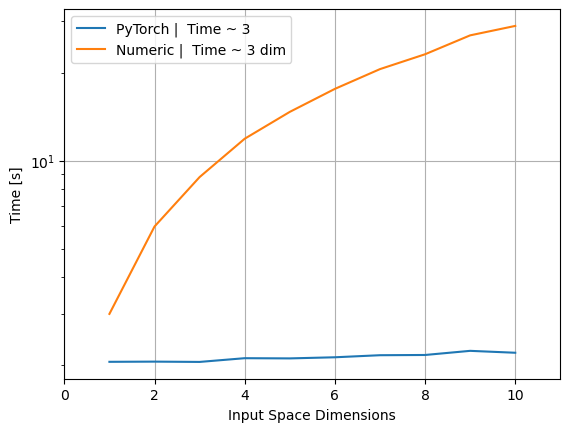

In [30]:

import matplotlib.pyplot as plt

plt.figure()

n_size_vec = np.arange(1, 11, 1)
print(n_size_vec)

plt.plot(n_size_vec, mean_torch_time, label="PyTorch |  Time ~ 3")
plt.plot(n_size_vec, mean_num_time, label="Numeric |  Time ~ 3 dim")
plt.xlim(0, 11)
plt.yscale('log')
plt.legend()
plt.xlabel("Input Space Dimensions")
plt.ylabel("Time [s]")
plt.grid()
plt.savefig("scaling_grads.png")


from scipy.stats import linregress

fit_torch = linregress(n_size_vec, mean_torch_time)
print(fit_torch)
fit_num = linregress(n_size_vec, mean_num_time)
print(fit_num)